In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');

In [2]:
def psd2th_wn(freq,psd,dur):
    def psdinteg(freq,psd):
        f = freq; y = psd;
        ndata = len(y);
        a = np.zeros(ndata-1);
        for i in range(ndata-1):
            if y[i] != 0 and y[i+1] != 0:
                n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
                if n == -1:
                    a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
                else:
                    a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
        return np.sqrt(sum(a))
    def log_interp(x,x_spec,y_spec):
        return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec), left=-10, right=-10);
    
    fmax = max(freq);
    tmax = dur;
    fs = fmax * 20.
    dt = 1 / fs

    spec_grms = psdinteg(freq,psd);

    Nt = int(np.ceil(tmax / dt))
    Nt3 = 3 * Nt
    
    # num_fft = 2의 n승
    Nt=2**int(np.ceil(np.log(Nt)/np.log(2)));  
    df = 1. / (Nt * dt);
    
    # White Noise
    wn = np.random.normal(0,1,Nt);
    
    Nf = int(Nt / 2)

    fft_freq = np.linspace(0, (Nf - 1) * df, Nf)
    fft_freq2 = np.linspace(0, (Nt - 1) * df, Nt)
    
    spec = np.zeros(Nf, float)
    sq_spec = np.zeros(Nf, float)
    
    js = 0
    
    if(fft_freq[0]<=0):
        fft_freq[0]=0.5*fft_freq[1];        
    
    sq_spec = np.sqrt(log_interp(fft_freq,freq,psd));
    
    Y = np.zeros(Nt, complex)

    YF = np.fft.fft(wn)
    
    YFn=YF[0:Nf]

    Y[0:Nf]=sq_spec*YFn

    Y[0]=0.
    
    for j in range(1, Nf):
        Y[Nt - j] = complex(Y[j].real, -Y[j].imag)
    
    YI = np.fft.ifft(Y)  
    
    psd_th = YI.real
    
    Nt = len(psd_th)
    
    time = np.linspace(0, (Nt - 1) * dt, Nt)
    
    syn_grms = np.std(psd_th)
    
    psd_th *= (spec_grms / syn_grms)
    
    return time,psd_th;

In [3]:
# Rectangular PSD
def Gr(f,f1,p1,f2,p2,A1,A2):
    out = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] >= f1 and f[i] <= p1:
            out[i] = A1
        elif f[i] >= f2 and f[i] <= p2:
            out[i] = A2;
    return out;

In [4]:
f1 = 10; p1 = 30; f2 = 95; p2 = 125; A1 = 1500; A2 = 300;
f = np.linspace(0,130,1000);
psd1 = Gr(f,f1,p1,f2,p2,A1,A2);

In [5]:
t1,th1 = psd2th_wn(f,psd1,10000);
t2,th2 = psd2th_wn(f,psd1,500);
t3,th3 = psd2th_wn(f,psd1,100);

In [9]:
dt1 = t1[1] - t1[0];
freq_syn1,psd_syn1 = welch(th1,fs = 1/dt1,nperseg=2**12);
dt2 = t2[1] - t2[0];
freq_syn2,psd_syn2 = welch(th2,fs = 1/dt2,nperseg=2**12);
dt3 = t3[1] - t3[0];
freq_syn3,psd_syn3 = welch(th3,fs = 1/dt3,nperseg=2**12);

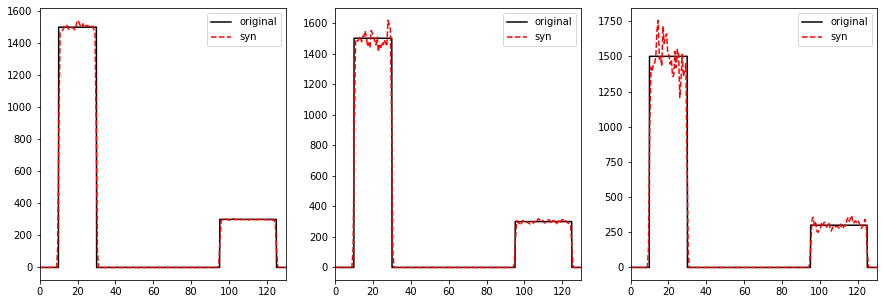

In [10]:
plt.figure(figsize=(15,5));
plt.subplot(131);
plt.plot(f,psd1,'k-',label='original');
plt.plot(freq_syn1,psd_syn1,'r--',label='syn'); plt.legend(loc='upper right'); plt.xlim(0,130);
plt.subplot(132);
plt.plot(f,psd1,'k-',label='original');
plt.plot(freq_syn2,psd_syn2,'r--',label='syn'); plt.legend(loc='upper right'); plt.xlim(0,130);
plt.subplot(133);
plt.plot(f,psd1,'k-',label='original');
plt.plot(freq_syn3,psd_syn3,'r--',label='syn'); plt.legend(loc='upper right'); plt.xlim(0,130);